In [1]:
import pandas as pd
import os
# %matplotlib widget
%matplotlib inline
from ipywidgets import *
import matplotlib.pyplot as plt
import random
import seaborn
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from datetime import datetime

In [9]:
def fillMissingMeasurments(df):
    # Create a list that contain the hours of expected measurments 
    hours = list(range(0, 24))
    expectedTimes = []
    for hour in hours:
        minutes = list(range(0, 60, 5))
        for minute in minutes:
            expectedTimes.append('{:02d}'.format(hour) + ":" + '{:02d}'.format(minute))
    # Extract the date from the incomplete df
    date = df["Date"].iloc[0]
    # For every missing row add a null row with values only at Time and Date columns
    i = 0
    for time in expectedTimes:
        # Create an empty row as a dictionary
        null_row = pd.DataFrame.from_dict({"Time": [time], "Date": [date]})
        if i >= len(df.index):
            # Missing values at the end of the dataframe
            df = pd.concat([df, null_row], ignore_index=True)
            df.reset_index(drop=True)
        elif time != df.iloc[i]["Time"]:
            # Missing values are inside the dataframe rows
            temp = pd.concat([df[:i], null_row], ignore_index=True)
            df = pd.concat([temp, df.iloc[i:]], ignore_index=True)
            df.reset_index(drop=True)
        i+=1
    return df

In [2]:
# Given a folder full of .csv files, return a data frame
# containing all the data. 
# relPathToFolder example (../path/to/folder/)
def getFolderToDataframe(relPathToFolder):
    # Initialize an empty dataframe
    df = pd.DataFrame()
    # Forall files in the directory
    for day in os.listdir(relPathToFolder):
        curFile = relPathToFolder + day
        if os.stat(curFile).st_size == 0 : continue
        # Fix Time and Date into a datetime object
        tempDf = pd.read_csv(curFile)
        tempDf["Date"] = day.split(sep='.')[0]
        # Remove redundant row (measurment for time 00:00 of the next day)
        # How I came up with 288: 
        # (24h in a day = 1440 minutes => 1440/5 = 288 measurments => measurments[0:287] 
        #   => iloc does not include the right bound, hence 288)
        tempDf = tempDf.iloc[0:288]
        if(len(tempDf.index) != 288):
            tempDf = fillMissingMeasurments(tempDf)
            if(len(tempDf.index) != 288):
                raise Exception("Missing rows, size of data = " + str(len(tempDf.index)))
        # Append tempDf to the old one
        df = pd.concat([df, tempDf], ignore_index=True)
    # Convert Date and Time into objects 
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d").dt.date
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M").dt.time
    # Reset indexes and drop the indexes for each individual day
    return df

In [3]:
# Functions that will prepare dataframes for clustering - substitute NaNs with actual values (averages)

# Fill NaNs in df with the average of that time of the other days
def substituteNanWithTimeAvg(df):
    avgDf = df.groupby("Time").mean().reset_index()
    for key, values in df.iteritems():
        cnt = -1
        for value in values:
            cnt += 1
            if pd.isna(value):
                row = df.iloc[cnt]
                df.loc[(df["Time"] == row.Time) & (df["Date"] == row.Date), key] = avgDf.loc[avgDf["Time"] == row.Time, key].item()


# Substitute NaNs in df with the average values of the previous 2 hours and the next 2 hours of the NaN measurement
# Ended up not using this function because it was also returning a few NaNs
def get4hourAverage(colName, df, date, time, hours=2):
    dateDf = df.loc[df.Date == date]
    dateDf.Time = dateDf["Time"].apply(lambda x: int(x.strftime('%H%M')))
    minuteStr = time.strftime('%H%M')[-2:]
    startHour = int(time.strftime('%H')) - hours
    if startHour < 0:
        startHour = 24 + startHour
    endHour = int(time.strftime('%H')) + hours
    if endHour > 23:
        endHour = endHour - 24
    startTime = int(f"{startHour:02d}" + minuteStr)
    endTime = int(f"{endHour:02d}" + minuteStr)
    if(startHour > endHour):
        avg = dateDf.loc[(dateDf.Time >= startTime) | (dateDf.Time <= endTime)][colName]
        return avg.mean()
    avg = dateDf.loc[(dateDf.Time >= startTime) & (dateDf.Time <= endTime)][colName]
    return avg.mean()

In [12]:
# Load demand
demandDf = getFolderToDataframe("C:/Users/user/Desktop/semester8/data mining/demand/")
demandDf = demandDf.rename(columns={"Current demand": "current_demand", "Hour ahead forecast": "hour_ahead_forecast", "Day ahead forecast": "day_ahead_forecast"})
demandDf.describe().T

## Fill NaNs in demandDf
substituteNanWithTimeAvg(demandDf)
if demandDf.isnull().values.any():
    raise Warning("demandDf still has NaN values!")

In [13]:
# Load sources
sourcesDf = getFolderToDataframe('C:/Users/user/Desktop/semester8/data mining/sources/')

## Cleanup
# Noticed that sources dataframe has two columns with same name but different capitalization.

# Natural gas - Natural Gas
# Important: Check if there are rows where both columns contain a value
cntBothNotNaN_gas = sourcesDf.loc[~((pd.isnull(sourcesDf["Natural gas"])) | (pd.isnull(sourcesDf["Natural Gas"])))]["Date"].count()
print(f"Natural gas: {cntBothNotNaN_gas} rows where both columns contain an actual value")

# Large hydro - Large Hydro
# Important: Check if there are rows where both columns contain a value
cntBothNotNaN_hydro = sourcesDf.loc[~((pd.isnull(sourcesDf["Large hydro"])) | (pd.isnull(sourcesDf["Large Hydro"])))]["Date"].count()
print(f"Large hydro: {cntBothNotNaN_hydro} rows where both columns contain an actual value")

if cntBothNotNaN_gas or cntBothNotNaN_hydro: raise Exception("There are conflicting values in your dataset")

# Since there are no conflicting values - I may change the capitalization and merge the columns
# Convert all column names to lowercase
sourcesDf.columns = sourcesDf.columns.str.lower()

# Sum the values of the distinct columns into one
sourcesDf[["temp natural gas", "temp large hydro"]] = sourcesDf[["natural gas", "large hydro"]].groupby(level=0, axis=1).sum()
# Drop the redundant columns
sourcesDf = sourcesDf.drop(columns=["natural gas", "large hydro"])
# Rename temp columns to their final names
# Also fix date and time so it works with my hardcoded strings in plotColumnByTime_forDates()
sourcesDf.rename(columns={
    "temp natural gas": "natural gas",
    "temp large hydro": "large hydro",
    "date": "Date",
    "time": "Time"
    }, inplace="True")

## Print the statistics of the clean dataset
print(sourcesDf.describe().T)

## Fill NaNs in sourcesDf
substituteNanWithTimeAvg(sourcesDf)
if sourcesDf.isnull().values.any():
    raise Warning("sourcesdDf still has NaN values!")

Natural gas: 0 rows where both columns contain an actual value
Large hydro: 0 rows where both columns contain an actual value
                count         mean          std       min     25%     50%  \
solar        315594.0  3560.611615  4373.706624    -145.0   -34.0   114.0   
wind         315594.0  2021.702320  1300.586403   -2476.0   869.0  1833.0   
geothermal   315306.0   890.270693   115.981209    -134.0   866.0   909.0   
biomass      315594.0   311.255357    48.244726     125.0   279.0   315.0   
biogas       315594.0   212.566969    15.383158     101.0   204.0   213.0   
small hydro  315594.0   264.017126   778.106278   -2826.0   166.0   227.0   
coal         315594.0    14.244108     4.574650      -8.0    11.0    15.0   
nuclear      315594.0  1866.838238   578.834088     -74.0  1145.0  2259.0   
batteries    315594.0    -5.018828   191.050928   -1614.0   -31.0    -3.0   
imports      315306.0  6029.318386  2614.757272  -22949.0  4250.0  6466.0   
other        315594.0     0

In [14]:
sourcesDf

,Time,solar,wind,geothermal,biomass,biogas,small hydro,coal,nuclear,batteries,imports,other,Date,natural gas,large hydro
0,00:00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,6.0,6254.0,0.0,2019-01-01,1924.0,7326.0
1,00:05:00,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,65.0,6266.0,0.0,2019-01-01,1866.0,7200.0
2,00:10:00,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,64.0,6319.0,0.0,2019-01-01,1849.0,7057.0
3,00:15:00,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,25.0,6354.0,0.0,2019-01-01,1827.0,7007.0
4,00:20:00,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,32.0,6360.0,0.0,2019-01-01,1840.0,6970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315643,23:35:00,-33.0,3778.0,882.0,287.0,203.0,187.0,20.0,2264.0,-144.0,8331.0,0.0,2021-12-31,1205.0,7287.0
315644,23:40:00,-32.0,3755.0,882.0,285.0,203.0,188.0,20.0,2265.0,-176.0,8414.0,0.0,2021-12-31,1206.0,7245.0
315645,23:45:00,-31.0,3751.0,882.0,285.0,205.0,188.0,20.0,2265.0,-234.0,8505.0,0.0,2021-12-31,1216.0,7222.0
315646,23:50:00,-32.0,3793.0,882.0,284.0,203.0,188.0,20.0,2264.0,-294.0,8526.0,0.0,2021-12-31,1208.0,7239.0


In [15]:
demandDf

,Time,day_ahead_forecast,hour_ahead_forecast,current_demand,Date
0,00:00:00,23437.0,22290.0,22216.0,2019-01-01
1,00:05:00,22363.0,22089.0,22106.0,2019-01-01
2,00:10:00,22363.0,22089.0,22130.0,2019-01-01
3,00:15:00,22363.0,22089.0,22040.0,2019-01-01
4,00:20:00,22363.0,21867.0,21963.0,2019-01-01
...,...,...,...,...,...
315643,23:35:00,23482.0,22823.0,22939.0,2021-12-31
315644,23:40:00,23482.0,22823.0,22855.0,2021-12-31
315645,23:45:00,23482.0,22823.0,22812.0,2021-12-31
315646,23:50:00,23482.0,22583.0,22723.0,2021-12-31


# Γ

In [16]:
X=sourcesDf[['Time','coal','nuclear','natural gas']]

In [17]:
X

,Time,coal,nuclear,natural gas
0,00:00:00,11.0,2273.0,1924.0
1,00:05:00,11.0,2273.0,1866.0
2,00:10:00,11.0,2272.0,1849.0
3,00:15:00,11.0,2272.0,1827.0
4,00:20:00,11.0,2273.0,1840.0
...,...,...,...,...
315643,23:35:00,20.0,2264.0,1205.0
315644,23:40:00,20.0,2265.0,1206.0
315645,23:45:00,20.0,2265.0,1216.0
315646,23:50:00,20.0,2264.0,1208.0


In [18]:
Y=demandDf[['current_demand']]

In [19]:
Y

,current_demand
0,22216.0
1,22106.0
2,22130.0
3,22040.0
4,21963.0
...,...
315643,22939.0
315644,22855.0
315645,22812.0
315646,22723.0


In [20]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
#ss2 = StandardScaler()

X_ss = ss.fit_transform(X[['coal','nuclear','natural gas']])
Y_mm = mm.fit_transform(Y) 

In [24]:
#split in trainset/testset at 80/20 ratio

X_train = X_ss[:252518, :]
X_test = X_ss[252518:, :]

Y_train = Y_mm[:252518, :]
Y_test =Y_mm[252518:, :]

In [25]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

Y_train_tensors = Variable(torch.Tensor(Y_train))
Y_test_tensors = Variable(torch.Tensor(Y_test))

In [26]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [27]:
print("Training Shape", X_train_tensors_final.shape, Y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, Y_test_tensors.shape) 

Training Shape torch.Size([252518, 1, 3]) torch.Size([252518, 1])
Testing Shape torch.Size([63130, 1, 3]) torch.Size([63130, 1])


In [234]:
num_epochs = 300 #1000 epochs*
learning_rate = 1*1e-3/5 #0.001 lr*

input_size = 3 #number of features
hidden_size= 64 #number of features in hidden state*
num_layers = 1 #number of stacked lstm layers*

num_classes = 1 #number of output classes 

In [235]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 200,bias=True) #fully connected 1
        self.fc = nn.Linear(200, num_classes,bias=True) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        return out
 

In [236]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [237]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [238]:
ERRORS=[]
VALS=[]
for epoch in range(num_epochs):
    
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, Y_train_tensors)
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    
    with torch.no_grad():
        outputs_test = lstm1.forward(X_test_tensors_final) #forward pass
        val_loss=criterion(outputs_test, Y_test_tensors)
    ERRORS.append(loss.item())
    VALS.append(val_loss.item())
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f, val loss: %1.5f" % (epoch, loss.item(), val_loss.item())) 

Epoch: 0, loss: 0.16243, val loss: 0.18101
Epoch: 10, loss: 0.13818, val loss: 0.15730
Epoch: 20, loss: 0.11589, val loss: 0.13522
Epoch: 30, loss: 0.09547, val loss: 0.11476
Epoch: 40, loss: 0.07677, val loss: 0.09584
Epoch: 50, loss: 0.05969, val loss: 0.07825
Epoch: 60, loss: 0.04425, val loss: 0.06196
Epoch: 70, loss: 0.03086, val loss: 0.04733
Epoch: 80, loss: 0.02011, val loss: 0.03480
Epoch: 90, loss: 0.01238, val loss: 0.02478
Epoch: 100, loss: 0.00769, val loss: 0.01738
Epoch: 110, loss: 0.00548, val loss: 0.01242
Epoch: 120, loss: 0.00471, val loss: 0.00952
Epoch: 130, loss: 0.00444, val loss: 0.00805
Epoch: 140, loss: 0.00424, val loss: 0.00737
Epoch: 150, loss: 0.00406, val loss: 0.00706
Epoch: 160, loss: 0.00391, val loss: 0.00685
Epoch: 170, loss: 0.00379, val loss: 0.00667
Epoch: 180, loss: 0.00370, val loss: 0.00649
Epoch: 190, loss: 0.00361, val loss: 0.00630
Epoch: 200, loss: 0.00353, val loss: 0.00615
Epoch: 210, loss: 0.00347, val loss: 0.00601
Epoch: 220, loss: 0.0

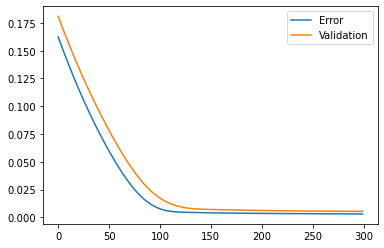

In [239]:
plt.plot(ERRORS[:],label='Error')
plt.plot(VALS[:],label='Validation')
plt.legend()
plt.show() 

In [240]:
df_X_ss = ss.transform(X[['coal','nuclear','natural gas']]) #old transformers
df_Y_mm = mm.transform(Y) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_Y_mm = Variable(torch.Tensor(df_Y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

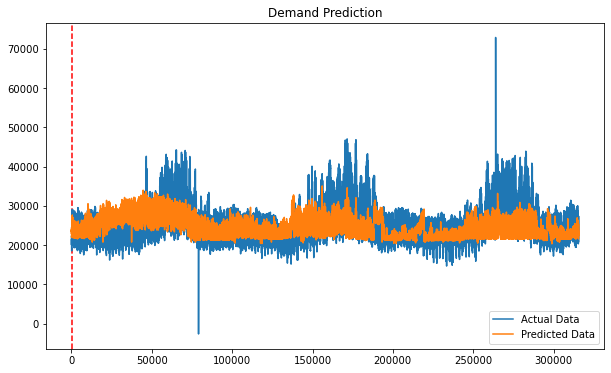

In [241]:
k=4000
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_Y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
#data_predict =data_predict
#dataY_plot =dataY_plot
#plot
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot[:], label='Actual Data') #actual plot
plt.plot(data_predict[:], label='Predicted Data') #predicted plot
plt.title('Demand Prediction')
plt.legend()
plt.show() 